## Predicting Churn Rate

I'm going to predict the churn rate for Telco Customers using Logistic Regression first and then comparing to other models such as Decision Tree and Random Forest classifiers, along with their metric scores.

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#### Importing dataset

In [75]:
data = pd.read_csv('./Files/WA_Fn-UseC_-Telco-Customer-Churn.csv')

# Display all columns
pd.options.display.max_columns = None

display(data.head(), data.shape)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


(7043, 21)

#### Standardize column's names

In [76]:
# Lower case
cols = []
for col in data.columns:
    cols.append(col.lower())

data.columns = cols

In [77]:
# Add underscore
column_mapping = {
    'customerid': 'customer_id',
    'seniorcitizen': 'senior_citizen',
    'phoneservice': 'phone_service',
    'multiplelines': 'multiple_lines',
    'internetservice': 'internet_service',
    'onlinesecurity': 'online_security',
    'onlinebackup': 'online_backup',
    'deviceprotection': 'device_protection',
    'techsupport': 'tech_support',
    'streamingtv': 'streaming_tv',
    'streamingmovies': 'streaming_movies',
    'paperlessbilling': 'paperless_billing',
    'paymentmethod': 'payment_method',
    'monthlycharges': 'monthly_charges',
    'totalcharges': 'total_charges'
}

data = data.rename(columns=column_mapping)
data.columns

Index(['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents',
       'tenure', 'phone_service', 'multiple_lines', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'contract', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges', 'churn'],
      dtype='object')

#### Data cleaning

In [78]:
# Check column types and NaN values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   gender             7043 non-null   object 
 2   senior_citizen     7043 non-null   int64  
 3   partner            7043 non-null   object 
 4   dependents         7043 non-null   object 
 5   tenure             7043 non-null   int64  
 6   phone_service      7043 non-null   object 
 7   multiple_lines     7043 non-null   object 
 8   internet_service   7043 non-null   object 
 9   online_security    7043 non-null   object 
 10  online_backup      7043 non-null   object 
 11  device_protection  7043 non-null   object 
 12  tech_support       7043 non-null   object 
 13  streaming_tv       7043 non-null   object 
 14  streaming_movies   7043 non-null   object 
 15  contract           7043 non-null   object 
 16  paperless_billing  7043 

There seems to be no presence of NaN values.

- Convert 'SeniorCitizen' to categorical

In [79]:
data['senior_citizen'].value_counts(dropna=False)

0    5901
1    1142
Name: senior_citizen, dtype: int64

The values of 0 and 1 used to indicate the absence or presence of senior citizen status are considered classificatory, rather than numerical, as they represent two distinct categories rather than continuous values on a numerical scale.

In [80]:
data['senior_citizen'] = data['senior_citizen'].astype('object')

- Convert 'TotalCharges' to numerical

In [81]:
data['total_charges'].value_counts(dropna=False)

          11
20.2      11
19.75      9
20.05      8
19.9       8
          ..
6849.4     1
692.35     1
130.15     1
3211.9     1
6844.5     1
Name: total_charges, Length: 6531, dtype: int64

In [82]:
# There are some rows with an empty value
data.loc[488,'total_charges']

' '

In [83]:
# Deal with empty rows
empty_rows = data[data['total_charges'] == ' ']

display(empty_rows[['customer_id','tenure','total_charges']].head(), empty_rows.shape)

,customer_id,tenure,total_charges
488,4472-LVYGI,0,
753,3115-CZMZD,0,
936,5709-LVOEQ,0,
1082,4367-NUYAO,0,
1340,1371-DWPAZ,0,


(11, 21)

In [84]:
# Replace for 0 (as 'Tenure' = 0 in all them)
data['total_charges'] = data['total_charges'].replace(' ',0)

In [85]:
# Check no empty rows remain
empty_rows = data[data['total_charges'] == ' ']
empty_rows.shape

(0, 21)

In [86]:
# Convert'TotalCharges' to numerical
data['total_charges'] = pd.to_numeric(data['total_charges'])

#### Data distribution

Numerical data

In [89]:
# Select numerical columns
numerical = data.select_dtypes(include=np.number)
display(numerical.columns,numerical.shape)

Index(['tenure', 'monthly_charges', 'total_charges'], dtype='object')

(7043, 3)

In [90]:
# NaN values
numerical.isna().sum()

tenure             0
monthly_charges    0
total_charges      0
dtype: int64

In [91]:
# Info
numerical.describe().T

,count,mean,std,min,25%,50%,75%,max
tenure,7043.0,32.371149,24.559481,0.00,9.00,29.00,55.00,72.00
monthly_charges,7043.0,64.761692,30.090047,18.25,35.50,70.35,89.85,118.75
total_charges,7043.0,2279.734304,2266.794470,0.00,398.55,1394.55,3786.60,8684.80


    - First, the mean tenure of customers is 32 months, with a standard deviation of 24. The minimum tenure is 0 months, indicating that there are new customers in the dataset. The maximum tenure is 72 months, which suggests that some customers have been with the company for a long time.

    - Second, the mean monthly charge is $64.76, with a standard deviation of $30.09. The minimum monthly charge is $18.25, which seems low, while the maximum monthly charge is $118.75, suggesting that some customers pay a premium for the services.

    - Finally, the mean total charges of customers are $2,279.73, with a standard deviation of $2,266.79. The minimum total charge is $0.00, denoting that some customers may have just joined the service, while the maximum total charge is $8,684.80, indicating that some customers have paid a significant amount over time.

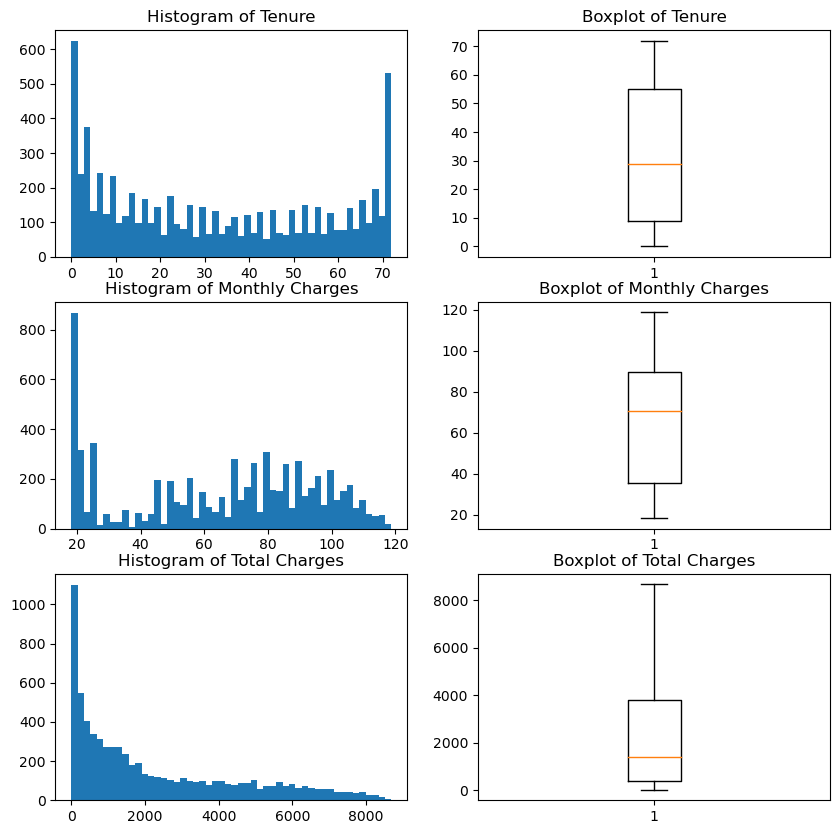

In [92]:
# Plot figure of data distribution
fig, axs = plt.subplots(3, 2, figsize=(10, 10))

# Plot histogram and boxplot for MonthlyCharges
axs[0][0].hist(data['tenure'], bins=50)
axs[0][0].set_title('Histogram of Tenure')
axs[0][1].boxplot(data['tenure'])
axs[0][1].set_title('Boxplot of Tenure')

# Plot histogram and boxplot for MonthlyCharges
axs[1][0].hist(data['monthly_charges'], bins=50)
axs[1][0].set_title('Histogram of Monthly Charges')
axs[1][1].boxplot(data['monthly_charges'])
axs[1][1].set_title('Boxplot of Monthly Charges')

# Plot histogram and boxplot for TotalCharges
axs[2][0].hist(data['total_charges'], bins=50)
axs[2][0].set_title('Histogram of Total Charges')
axs[2][1].boxplot(data['total_charges'])
axs[2][1].set_title('Boxplot of Total Charges')

plt.show()

Categorical data

In [93]:
categorical = data.select_dtypes(include='object')
display(categorical.columns,categorical.shape)

Index(['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents',
       'phone_service', 'multiple_lines', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'contract', 'paperless_billing',
       'payment_method', 'churn'],
      dtype='object')

(7043, 18)

In [94]:
for col in categorical.columns:
    print("Column: ",col)
    print("Unique values: ", categorical[col].nunique())
    print(categorical[col].value_counts(dropna=False),"\n")

Column:  customer_id
Unique values:  7043
7590-VHVEG    1
3791-LGQCY    1
6008-NAIXK    1
5956-YHHRX    1
5365-LLFYV    1
             ..
9796-MVYXX    1
2637-FKFSY    1
1552-AAGRX    1
4304-TSPVK    1
3186-AJIEK    1
Name: customer_id, Length: 7043, dtype: int64 

Column:  gender
Unique values:  2
Male      3555
Female    3488
Name: gender, dtype: int64 

Column:  senior_citizen
Unique values:  2
0    5901
1    1142
Name: senior_citizen, dtype: int64 

Column:  partner
Unique values:  2
No     3641
Yes    3402
Name: partner, dtype: int64 

Column:  dependents
Unique values:  2
No     4933
Yes    2110
Name: dependents, dtype: int64 

Column:  phone_service
Unique values:  2
Yes    6361
No      682
Name: phone_service, dtype: int64 

Column:  multiple_lines
Unique values:  3
No                  3390
Yes                 2971
No phone service     682
Name: multiple_lines, dtype: int64 

Column:  internet_service
Unique values:  3
Fiber optic    3096
DSL            2421
No             1526

No NaN values are present and each categorical variable has 4 or fewer unique values.
The exception is 'customer_id,' which will be removed in the next step.

### Preprocess data for modelling

In [95]:
# Drop unnecessary column
data = data.drop('customer_id', axis = 1)

#### X/y Split

In [96]:
# Target = 'Churn'
y = data['churn']
X = data.drop('churn', axis = 1)

#### Train-Test Split

In [97]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Numerical-Categorical X Split

In [98]:
# Numericals
X_train_num = X_train.select_dtypes(include=np.number)
X_test_num = X_test.select_dtypes(include=np.number)

# Categoricals
X_train_cat = X_train.select_dtypes(include='object')
X_test_cat = X_test.select_dtypes(include='object')

##### Scaling Numericals

In [99]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler object
scaler = StandardScaler()

# Fit and transform the scaler on the numerical train features
X_train_num_scaled = scaler.fit_transform(X_train_num)

# Transform the scaler on the numerical test features
X_test_num_scaled = scaler.transform(X_test_num)


##### Encoding Categoricals

In [100]:
from sklearn.preprocessing import OneHotEncoder

# Create the OneHotEncoder object
encoder = OneHotEncoder(drop='first')

# Fit and transform the encoder on the training categorical columns
train_encoded = encoder.fit_transform(X_train_cat)

# Transform the encoder on the testing categorical columns
test_encoded = encoder.transform(X_test_cat)

# Get the names of the encoded features
feature_names = encoder.get_feature_names_out(X_train_cat.columns)

# Convert the encoded array back into dataframes with the feature names
X_train_cat_encoded = pd.DataFrame(train_encoded.toarray(), columns=feature_names)
X_test_cat_encoded = pd.DataFrame(test_encoded.toarray(), columns=feature_names)


##### Combine scaled and encoded TRAIN data

In [101]:
# Combine the scaled numerical features and the categorical encoded features of the training data
train_processed = pd.concat([pd.DataFrame(X_train_num_scaled, columns=X_train_num.columns), X_train_cat_encoded.reset_index(drop=True)], axis=1)

##### Combine scaled and encoded TEST data

In [102]:
# Combine the numerical and categorical features back into a single dataframe for the test data
test_processed = pd.concat([pd.DataFrame(X_test_num_scaled, columns=X_train_num.columns), X_test_cat_encoded], axis=1)

### Logistic Regression Model

In [103]:
from sklearn.linear_model import LogisticRegression

# Create a logistic regression object
lr = LogisticRegression()

# Fit the model on the training data
lr.fit(train_processed, y_train)

# Predict on the test data
y_pred = lr.predict(test_processed)

display(y_pred[:10], y_test[:10])

array(['Yes', 'No', 'No', 'Yes', 'No', 'No', 'No', 'No', 'No', 'No'],
      dtype=object)

185     Yes
2715     No
3825     No
1807    Yes
132      No
1263    Yes
3732     No
1672     No
811     Yes
2526    Yes
Name: churn, dtype: object

#### Evaluate model's performance: accuracy, precision, recall and F1

In [104]:
# Evaluate the model performance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate accuracy
accuracy_lr = round(accuracy_score(y_test, y_pred), 2)

# Calculate precision
precision_lr = round(precision_score(y_test, y_pred, pos_label='Yes'), 2)

# Calculate recall
recall_lr = round(recall_score(y_test, y_pred, pos_label='Yes'), 2)

# Calculate F1 score
f1_lr = round(f1_score(y_test, y_pred, pos_label='Yes'), 2)

print('Accuracy:', accuracy_lr)
print('Precision:', precision_lr)
print('Recall:', recall_lr)
print('F1 score:', f1_lr)

Accuracy: 0.82
Precision: 0.69
Recall: 0.6
F1 score: 0.64


#### Confusion Matrix

In [105]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix

# Get the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix for Logistic Regression:\n")
print(pd.DataFrame(conf_matrix, columns=["Predicted No Churn", "Predicted Churn"], index=["Actual No Churn", "Actual Churn"]))


# Convert the confusion matrix values into percentages
cm_perc = conf_matrix / len(y_test) * 100

# Print the confusion matrix as a table
print("\nConfusion Matrix (Percentages):\n")
print(pd.DataFrame(cm_perc, columns=["Predicted No Churn", "Predicted Churn"], index=["Actual No Churn", "Actual Churn"]))


Confusion Matrix for Logistic Regression:

                 Predicted No Churn  Predicted Churn
Actual No Churn                 934              102
Actual Churn                    150              223

Confusion Matrix (Percentages):

                 Predicted No Churn  Predicted Churn
Actual No Churn           66.288148         7.239177
Actual Churn              10.645848        15.826828


### Alternative Models

#### Decision Tree Classifier

In [106]:
from sklearn.tree import DecisionTreeClassifier

# Initialize Decision Tree Classifier with hyperparameters
dt = DecisionTreeClassifier(max_depth=10, min_samples_split=10, random_state=42)

# Fit the model on train data
dt.fit(train_processed, y_train)

# Decision Tree predictions on test data
y_pred_dt_test = dt.predict(test_processed)

In [107]:
# Calculate accuracy
accuracy_dt = round(accuracy_score(y_test, y_pred_dt_test), 2)

# Calculate precision
precision_dt = round(precision_score(y_test, y_pred_dt_test, pos_label='Yes'), 2)

# Calculate recall
recall_dt = round(recall_score(y_test, y_pred_dt_test, pos_label='Yes'), 2)

# Calculate F1 score
f1_dt = round(f1_score(y_test, y_pred_dt_test, pos_label='Yes'), 2)

print('Accuracy:', accuracy_dt)
print('Precision:', precision_dt)
print('Recall:', recall_dt)
print('F1 score:', f1_dt)

Accuracy: 0.76
Precision: 0.56
Recall: 0.5
F1 score: 0.53


In [108]:
# Generate confusion matrix for Decision Tree Classifier
cm_dt = confusion_matrix(y_test, y_pred_dt_test)
print("Confusion Matrix for Decision Tree Classifier:\n")
#print(cm_dt)
print(pd.DataFrame(cm_dt, columns=["Predicted No Churn", "Predicted Churn"], index=["Actual No Churn", "Actual Churn"]))

Confusion Matrix for Decision Tree Classifier:

                 Predicted No Churn  Predicted Churn
Actual No Churn                 890              146
Actual Churn                    187              186


#### Random Forest Classifier

In [109]:
from sklearn.ensemble import RandomForestClassifier

# Initialize Random Forest Classifier with hyperparameters
rf_clf = RandomForestClassifier(n_estimators=10, max_depth=10, random_state=42)

# Fit the model on train data
rf_clf.fit(train_processed, y_train)

# Random Forest predictions on test data
y_pred_rf_test = rf_clf.predict(test_processed)


In [110]:
# Calculate accuracy
accuracy_rf = round(accuracy_score(y_test, y_pred_rf_test), 2)

# Calculate precision
precision_rf = round(precision_score(y_test, y_pred_rf_test, pos_label='Yes'), 2)

# Calculate recall
recall_rf = round(recall_score(y_test, y_pred_rf_test, pos_label='Yes'), 2)

# Calculate F1 score
f1_rf = round(f1_score(y_test, y_pred_rf_test, pos_label='Yes'), 2)

print('Accuracy:', accuracy_rf)
print('Precision:', precision_rf)
print('Recall:', recall_rf)
print('F1 score:', f1_rf)

Accuracy: 0.81
Precision: 0.67
Recall: 0.55
F1 score: 0.6


In [111]:
# Generate confusion matrix for Random Forest Classifier
cm_rf = confusion_matrix(y_test, y_pred_rf_test)
print("Confusion Matrix for Random Forest Classifier:")
#print(cm_rf)
print(pd.DataFrame(cm_rf, columns=["Predicted No Churn", "Predicted Churn"], index=["Actual No Churn", "Actual Churn"]))

Confusion Matrix for Random Forest Classifier:
                 Predicted No Churn  Predicted Churn
Actual No Churn                 937               99
Actual Churn                    169              204


#### Oversampling - SMOTE

In [112]:
y_train.value_counts()

No     4138
Yes    1496
Name: churn, dtype: int64

In [113]:
# TRAIN DATA
display(train_processed.shape, y_train.shape)

(5634, 30)

(5634,)

In [114]:
from imblearn.over_sampling import SMOTE

# Instantiate SMOTE
smote = SMOTE(random_state=42)

# Fit SMOTE
X_train_resampled, y_train_resampled = smote.fit_resample(train_processed, y_train)

In [148]:
display(X_train_resampled.shape, y_train_resampled.shape, y_train_resampled.value_counts())

(8276, 30)

(8276,)

No     4138
Yes    4138
Name: churn, dtype: int64

In [115]:
# Logistic Regression
lr_os = LogisticRegression()
lr_os.fit(X_train_resampled, y_train_resampled)
y_pred_os = lr_os.predict(test_processed)

In [116]:
# Calculate accuracy
accuracy_lr_os = round(accuracy_score(y_test, y_pred_os), 2)

# Calculate precision
precision_lr_os = round(precision_score(y_test, y_pred_os, pos_label='Yes'), 2)

# Calculate recall
recall_lr_os = round(recall_score(y_test, y_pred_os, pos_label='Yes'), 2)

# Calculate F1 score
f1_lr_os = round(f1_score(y_test, y_pred_os, pos_label='Yes'), 2)

print('Accuracy:', accuracy_lr_os)
print('Precision:', precision_lr_os)
print('Recall:', recall_lr_os)
print('F1 score:', f1_lr_os)

Accuracy: 0.76
Precision: 0.53
Recall: 0.83
F1 score: 0.64


In [117]:
# Generate confusion matrix for Random Forest Classifier
cm_lr_os = confusion_matrix(y_test, y_pred_os)
print("Confusion Matrix for Logistic Regression Oversampled:")
#print(cm_rf)
print(pd.DataFrame(cm_lr_os, columns=["Predicted No Churn", "Predicted Churn"], index=["Actual No Churn", "Actual Churn"]))

Confusion Matrix for Logistic Regression Oversampled:
                 Predicted No Churn  Predicted Churn
Actual No Churn                 755              281
Actual Churn                     62              311


### Summary Report

In [118]:
print("Confusion Matrix for Logistic Regression:\n")
print(pd.DataFrame(conf_matrix, columns=["Predicted No Churn", "Predicted Churn"], index=["Actual No Churn", "Actual Churn"]))

print("\n\nConfusion Matrix for Logistic Regression - SMOTE :\n")
print(pd.DataFrame(cm_lr_os, columns=["Predicted No Churn", "Predicted Churn"], index=["Actual No Churn", "Actual Churn"]))

print("\n\nConfusion Matrix for Decision Tree Classifier:\n")
print(pd.DataFrame(cm_dt, columns=["Predicted No Churn", "Predicted Churn"], index=["Actual No Churn", "Actual Churn"]))

print("\n\nConfusion Matrix for Random Forest Classifier:")
print(pd.DataFrame(cm_rf, columns=["Predicted No Churn", "Predicted Churn"], index=["Actual No Churn", "Actual Churn"]))

Confusion Matrix for Logistic Regression:

                 Predicted No Churn  Predicted Churn
Actual No Churn                 934              102
Actual Churn                    150              223


Confusion Matrix for Logistic Regression - SMOTE :

                 Predicted No Churn  Predicted Churn
Actual No Churn                 755              281
Actual Churn                     62              311


Confusion Matrix for Decision Tree Classifier:

                 Predicted No Churn  Predicted Churn
Actual No Churn                 890              146
Actual Churn                    187              186


Confusion Matrix for Random Forest Classifier:
                 Predicted No Churn  Predicted Churn
Actual No Churn                 937               99
Actual Churn                    169              204


In [119]:
# Create a dictionary to store the evaluation metrics for each classifier
results = {
    'Logistic Regression': [accuracy_lr, precision_lr, recall_lr, f1_lr],
    'Logistic Regression - SMOTE': [accuracy_lr_os, precision_lr_os, recall_lr_os, f1_lr_os],
    'Decision Tree': [accuracy_dt, precision_dt, recall_dt, f1_dt],
    'Random Forest Classifier': [accuracy_rf, precision_rf, recall_rf, f1_rf]
}

# Create a DataFrame from the dictionary and transpose it to swap rows and columns
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['Accuracy', 'Precision', 'Recall', 'F1 Score']).T

results_df


,Logistic Regression,Logistic Regression - SMOTE,Decision Tree,Random Forest Classifier
Accuracy,0.82,0.76,0.76,0.81
Precision,0.69,0.53,0.56,0.67
Recall,0.60,0.83,0.50,0.55
F1 Score,0.64,0.64,0.53,0.60


1. Logistic Regression has the highest accuracy score (0.82) among all the models, indicating that it is good at predicting the target variable overall. However, its precision and recall scores are moderate (0.69 and 0.60, respectively), suggesting that it may not be the best model for identifying true positive cases.



2. Logistic Regression with SMOTE has a lower accuracy score (0.76) than the base model, but it has a higher recall score (0.83) which means it is better at identifying true positive cases. However, its precision score is quite low (0.53), indicating that it may have more false positive cases.



3. Decision Tree has the lowest recall score (0.50), indicating that it has a high number of false negatives. However, it has a moderate precision score (0.56) which suggests that it may be good at identifying true positive cases but may not be the best model for predicting the target variable overall.



4. Random Forest Classifier has a high accuracy score (0.81), similar to that of Logistic Regression, and also has a relatively high precision score (0.67). However, its recall score (0.55) is quite low, indicating that it may have a high number of false negatives. Overall, it may be a good model for predicting the target variable with high precision, but may not be the best model for identifying all true positive cases.

    - Accuracy: checks the proportion of correctly predicted outcomes out of all cases. It is calculated as (TP + TN) / (TP + TN + FP + FN), where TN is the number of true negatives and FP is the number of false positives. Unlike precision and recall, which focus on the performance of the model in one specific class, accuracy measures the overall performance of the model across all classes.


    - Precision: Precision measures the proportion of true positives (correctly predicted positive cases) out of all predicted positive cases. It is calculated as TP / (TP + FP), where TP is the number of true positives and FP is the number of false positives.


    - Recall: Recall measures the proportion of true positives out of all actual positive cases. It is calculated as TP / (TP + FN), where TP is the number of true positives and FN is the number of false negatives.


    - F1 score: The F1 score is a weighted average of precision and recall, calculated as 2 * (precision * recall) / (precision + recall).

In [ ]:
# Save clean dataset
data.to_csv('./Files/clean_data_churn.csv')

Now, to analyze the profiles of the detected and undetected customers who churned, I'm going to also save a dataframe with test rows to use it in the next kernel.

In [144]:
# Check same length
display('Y test length: ',y_test.shape, 'Y predicted logreg-smote length: ', y_pred_os.shape)

'Y test length: '

(1409,)

'Y predicted logreg-smote length: '

(1409,)

In [145]:
# Get all columns from original dataframe for all rows included in the test set
test_data = data.loc[y_test.index]

# Add column with predicted values for these rows
test_data['churn_predictions'] = y_pred_os
display(test_data.head(),test_data.shape)

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,total_charges,churn,churn_predictions
185,Female,0,Yes,No,1,No,No phone service,DSL,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,24.80,24.80,Yes,Yes
2715,Male,0,No,No,41,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Bank transfer (automatic),25.25,996.45,No,No
3825,Female,0,Yes,Yes,52,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.35,1031.70,No,No
1807,Female,0,No,No,1,Yes,No,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Electronic check,76.35,76.35,Yes,Yes
132,Male,0,No,No,67,Yes,No,DSL,No,No,No,Yes,No,No,Two year,No,Bank transfer (automatic),50.55,3260.10,No,No


(1409, 21)

In [146]:
# Save clean dataset
test_data.to_csv('./Files/test_data_churn.csv')